# Ch5. back propagation

이번장에서는 해석적인 방법으로 network를 학습시켜보자

In [1]:
import numpy as np

In [2]:
def cross_entropy_error_one_hot(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y)) / batch_size

In [3]:
def _numerical_grad(f, x):
    h = 1e-4
    grad = np.zeros(x.size)

    for dim in range(x.size):
        temp = x[dim]

        x[dim] = temp - h
        f1 = f(x)

        x[dim] = temp + h
        f2 = f(x)

        grad[dim] = (f2 - f1) / (2 * h)

    return grad

def numerical_gradient_batch(f, X):
    if X.ndim == 1:
        return _numerical_grad(f, X)

    grad = np.zeros_like(X)
    for idx in range(X.shape[0]):
        grad[idx] = _numerical_grad(f, X[idx])

    return grad

# not work
def numerical_gradient_batch_v2(f, X):
    h = 1e-4
    if X.ndim == 1:
        return _numerical_grad(f, X)

    grad = np.zeros_like(X)
    for col in range(X.shape[1]):
        H = np.zeros_like(X)
        H[:, col] += h

        f1 = f(X - H)
        f2 = f(X + H)

        grad[:, col] = (f2 - f1) / (2 * h)

    return grad


In [4]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x)  # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

### layer 구현

In [5]:
class ReLU:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

In [6]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self, x):
        self.x = x
        return np.dot(self.x, self.W) + self.b
    
    def backward(self, dout):        
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        dx = np.dot(dout, self.W.T)
        
        return dx

### softmax-with-loss

In [7]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error_one_hot(self.y, t)
        
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        
        return dx

### neural net 구성

In [8]:
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.1):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        
        self.params['b1'] = np.zeros(hidden_size)
        self.params['b2'] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = ReLU()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = ReLU()
        
        self.last_layer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    
    def loss(self, x, t):
        y = self.predict(x)
        
        return self.last_layer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y==t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient_batch(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient_batch(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient_batch(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient_batch(loss_W, self.params['b2'])
        
        return grads
    
    def gradient(self, x, t):
        self.loss(x, t)
        
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads

In [9]:
from dataset.mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [10]:
iters_num=10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

### train

In [11]:
net = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

train_loss_list = []
train_acc_list = []
test_acc_list = []

point_count = 0

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
        
    grad = net.gradient(x_batch, t_batch)
    
    net.params['W1'] -= learning_rate * grad['W1']
    net.params['b1'] -= learning_rate * grad['b1']
    net.params['W2'] -= learning_rate * grad['W2']
    net.params['b2'] -= learning_rate * grad['b2']
    
    loss = net.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % 100 == 0:
        point_count += 1
        
        train_acc = net.accuracy(x_train, t_train)
        test_acc = net.accuracy(x_test, t_test)
        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print(f"{i}th iter... test_acc: {test_acc}, train_acc: {train_acc}, loss: {loss}")

0th iter... test_acc: 0.0777, train_acc: 0.08396666666666666, loss: 2.289324441780502
100th iter... test_acc: 0.6815, train_acc: 0.6778, loss: 0.9634228327779931
200th iter... test_acc: 0.7172, train_acc: 0.7096833333333333, loss: 0.6833552282349273
300th iter... test_acc: 0.7284, train_acc: 0.7238833333333333, loss: 0.6247839063832608
400th iter... test_acc: 0.7364, train_acc: 0.7322833333333333, loss: 0.5770705409256907
500th iter... test_acc: 0.7441, train_acc: 0.7374333333333334, loss: 0.7069713492335761
600th iter... test_acc: 0.7442, train_acc: 0.7380333333333333, loss: 0.8242528346794429
700th iter... test_acc: 0.7487, train_acc: 0.7428833333333333, loss: 0.8001617315104668
800th iter... test_acc: 0.7498, train_acc: 0.7458666666666667, loss: 0.5855542801427963
900th iter... test_acc: 0.7512, train_acc: 0.7485, loss: 0.7084754085405711
1000th iter... test_acc: 0.7535, train_acc: 0.7512, loss: 0.6491848601802219
1100th iter... test_acc: 0.7546, train_acc: 0.75135, loss: 0.63145073

9600th iter... test_acc: 0.9669, train_acc: 0.9753, loss: 0.02881111602531049
9700th iter... test_acc: 0.9658, train_acc: 0.9763833333333334, loss: 0.04168306732947169
9800th iter... test_acc: 0.9662, train_acc: 0.9766666666666667, loss: 0.056980878014705416
9900th iter... test_acc: 0.9665, train_acc: 0.97645, loss: 0.06154268307639842


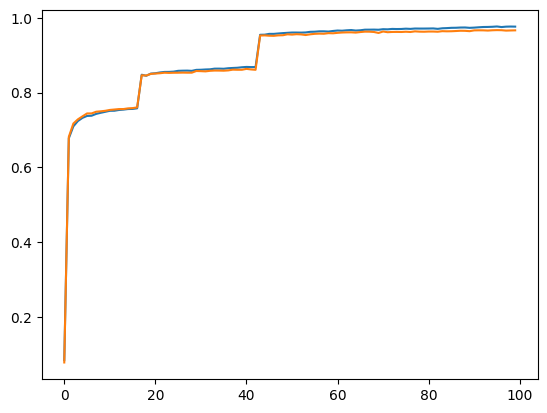

In [12]:
import matplotlib.pyplot as plt

plt.plot(np.arange(point_count), train_acc_list)
plt.plot(np.arange(point_count), test_acc_list)
plt.show()

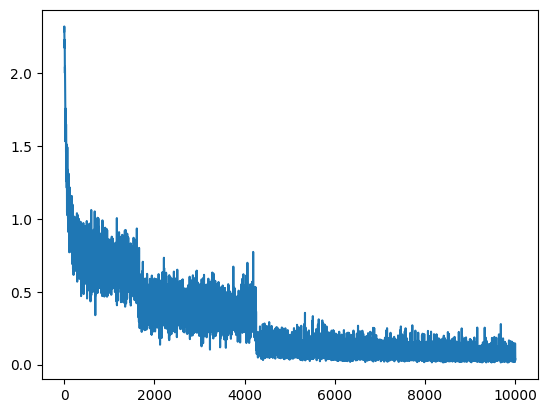

In [13]:
plt.plot(np.arange(iters_num), train_loss_list)
plt.show()